In [244]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
import pickle
import pandas as pd
from scipy.stats import pearsonr
import rasterio

from GCCM_gao import run_GCCM, embedding
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [144]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 14,          # Global font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 14,     # X and Y axis labels font size
    'xtick.labelsize': 11,    # X-axis tick labels font size
    'ytick.labelsize': 11,    # Y-axis tick labels font size
    'legend.fontsize': 11,    # Legend font size
})

## Data

In [235]:
# load data

x = rasterio.open('../Gao_code/raster/dTRI.tif') # cause
xMatrix = x.read(1)
xMatrix = xMatrix.T
y = rasterio.open('../Gao_code/raster/Cu.tif') # effect
yMatrix = y.read(1)
yMatrix = yMatrix.T
z = rasterio.open('../Gao_code/raster/nlights03.tif') # cause
zMatrix = z.read(1)
zMatrix = zMatrix.T
zMatrix = zMatrix.astype(float)

In [251]:
xMatrix.shape, yMatrix.shape, zMatrix.shape

((125, 131), (126, 132), (125, 131))

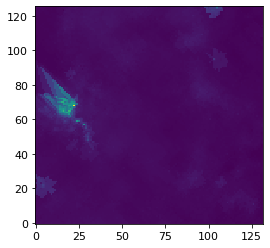

In [145]:
plt.imshow(yMatrix, origin='lower', interpolation='none')

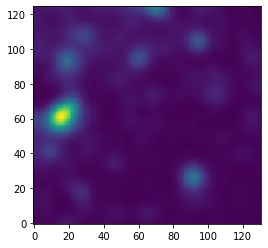

In [3]:
plt.imshow(xMatrix, origin='lower', interpolation='none')

In [250]:
correlation_coefficient, p_value = pearsonr(xMatrix.flatten(), yMatrix[1:, 1:].flatten()) #[:125, :131]
correlation_coefficient, p_value

(0.5081885953981038, 0.0)

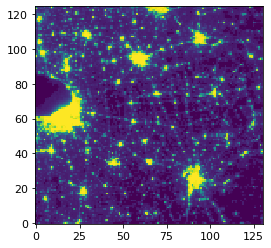

In [236]:
plt.imshow(zMatrix, origin='lower', interpolation='none')

In [249]:
correlation_coefficient, p_value = pearsonr(zMatrix.flatten(), yMatrix[1:, 1:].flatten())
correlation_coefficient, p_value

(0.2317785756243964, 1.2863871116548406e-198)

In [113]:
xEmbedings = embedding(xMatrix, E)
yEmbedings = embedding(yMatrix, E)
zEmbedings = embedding(zMatrix, E)

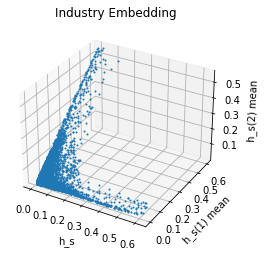

In [121]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xEmbedings[0].flatten(),np.mean(xEmbedings[1], axis=1),np.mean(xEmbedings[2], axis=1), '.', ms=2 )
#ax.plot(xEmbedings[0].flatten(),np.max(xEmbedings[1], axis=1), np.max(xEmbedings[2], axis=1), '.', ms=2 )
#ax.plot(xEmbedings[0].flatten(),xEmbedings[1][:,-1],xEmbedings[2][:,-1], '.' )
#ax.plot(np.mean(xEmbedings[2], axis=1),np.mean(xEmbedings[1], axis=1),xEmbedings[0].flatten(), '.' )
#ax.plot(np.mean(xEmbedings[1], axis=1),np.mean(xEmbedings[2], axis=1),np.mean(xEmbedings[3], axis=1), '.' )
ax.set_xlabel("h_s")
ax.set_ylabel("h_s(1) mean")
ax.set_zlabel("h_s(2) mean")
ax.set_title("Industry Embedding")

plt.show()

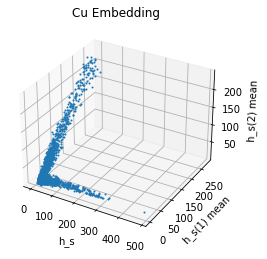

In [114]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(yEmbedings[0].flatten(),np.mean(yEmbedings[1], axis=1),np.mean(yEmbedings[2], axis=1), '.', ms=2 )
#ax.plot(yEmbedings[0].flatten(),yEmbedings[1][:,3],yEmbedings[2][:,3], '.' )

#ax.plot(np.mean(yEmbedings[1], axis=1),np.mean(yEmbedings[2], axis=1),np.mean(yEmbedings[3], axis=1), '.' )
ax.set_xlabel("h_s")
ax.set_ylabel("h_s(1) mean")
ax.set_zlabel("h_s(2) mean")
ax.set_title("Cu Embedding")

plt.show()

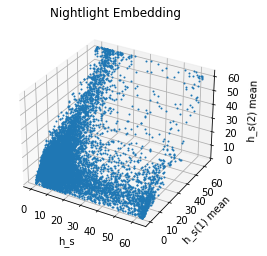

In [115]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(zEmbedings[0].flatten(),np.mean(zEmbedings[1], axis=1),np.mean(zEmbedings[2], axis=1), '.', ms=2 )
#ax.plot(zEmbedings[0].flatten(),zEmbedings[1][:,3],zEmbedings[2][:,3], '.' )

#ax.plot(np.mean(zEmbedings[1], axis=1),np.mean(zEmbedings[2], axis=1),np.mean(zEmbedings[3], axis=1), '.' )
ax.set_xlabel("h_s")
ax.set_ylabel("h_s(1) mean")
ax.set_zlabel("h_s(2) mean")
ax.set_title("Nightlight Embedding")

plt.show()

In [127]:
lib_sizes = np.arange(10,120,20)

## Gao results reproduced in python

In [252]:
# Load the results from file
# python results
with open('gao/Iresults.pkl', 'rb') as pickle_file:
    iresults = pickle.load(pickle_file)
with open('gao/Nresults.pkl', 'rb') as pickle_file:
    nresults = pickle.load(pickle_file)
# R results
iresultsr = pd.read_csv('../Gao_code/raster/results/Iresults.csv')
nresultsr = pd.read_csv('../Gao_code/raster/results/Nresults.csv')

In [171]:
ix_xmap_y = []
iy_xmap_x = []
for lib in lib_sizes:
    ix_xmap_y.append(iresults['x_xmap_y'][lib]['mean'])
    iy_xmap_x.append(iresults['y_xmap_x'][lib]['mean'])
nx_xmap_y = []
ny_xmap_x = []
for lib in lib_sizes:
    nx_xmap_y.append(nresults['x_xmap_y'][lib]['mean'])
    ny_xmap_x.append(nresults['y_xmap_x'][lib]['mean'])

**x cause**: Industry or Nightlight \
**y effect**: Cu

x xmap y embedding of x variable to predict y (information in x can predict y) so y (Cu) -> x (Industry) \
y xmap x embedding of y variable to predict x (information in  effect y can predict cause x) so x (Industry) -> y (Cu)

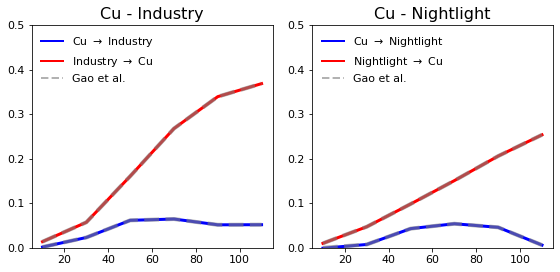

In [253]:
# Appendix figure
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(lib_sizes, ix_xmap_y, c='b', lw=3, label = r'Cu $\rightarrow$ Industry')
ax[0].plot(lib_sizes, iy_xmap_x, c='r', lw=3, label = r'Industry $\rightarrow$ Cu')

ax[0].plot(lib_sizes, list(iresultsr['x_xmap_y_means']), '--', c='grey', alpha=0.6, lw=4, label='Gao et al.')
ax[0].plot(lib_sizes, list(iresultsr['y_xmap_x_means']), '--', c='grey', alpha=0.6, lw=4)
ax[0].set_ylim(0,0.5)
ax[0].set_title('Cu - Industry')
legend = ax[0].legend(loc='upper left', frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)
    
ax[1].plot(lib_sizes, nx_xmap_y, c='b', lw=3, label = r'Cu $\rightarrow$ Nightlight')
ax[1].plot(lib_sizes, ny_xmap_x, c='r', lw=3, label = r'Nightlight $\rightarrow$ Cu')
ax[1].plot(lib_sizes, list(nresultsr['x_xmap_y_means']), '--', c='grey', alpha=0.6, lw=4, label='Gao et al.')
ax[1].plot(lib_sizes, list(nresultsr['y_xmap_x_means']), '--', c='grey', alpha=0.6, lw=4)
ax[1].set_ylim(0,0.5)
ax[1].set_title('Cu - Nightlight')
ax[1].set_ylim(0,0.5)
legend = ax[1].legend(loc='upper left', frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
plt.show()

## Corrected results

In [ ]:
# correct results are from R, change to python 

In [218]:
iresultsr_correct = pd.read_csv('../Gao_code/raster_corrected/results/Iresults_corrected.csv')
nresultsr_correct = pd.read_csv('../Gao_code/raster_corrected/results/Nresults_corrected.csv')

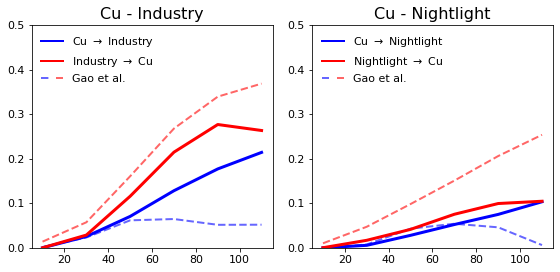

In [254]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
p1,= ax[0].plot(lib_sizes, ix_xmap_y, '--', c='b', alpha=0.6, lw=2, label='original')
p2,= ax[0].plot(lib_sizes, iy_xmap_x, '--', c='r', alpha=0.6, lw=2)
p3,= ax[0].plot(lib_sizes, list(iresultsr_correct['x_xmap_y_means']),  c='b',  lw=3, label = r'Cu $\rightarrow$ Industry')
p4,= ax[0].plot(lib_sizes, list(iresultsr_correct['y_xmap_x_means']),  c='r',  lw=3, label = r'Industry $\rightarrow$ Cu')
ax[0].set_ylim(0,0.5)
ax[0].set_title('Cu - Industry')
legend = ax[0].legend([p3, p4, (p1, p2)], [r'Cu $\rightarrow$ Industry', r'Industry $\rightarrow$ Cu', 'Gao et al.'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)}, 
                      loc='upper left', frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

p1,= ax[1].plot(lib_sizes, nx_xmap_y, '--', c='b', alpha=0.6, lw=2, label='original')
p2,= ax[1].plot(lib_sizes, ny_xmap_x, '--', c='r', alpha=0.6, lw=2)
p3,= ax[1].plot(lib_sizes, list(nresultsr_correct['x_xmap_y_means']),  c='b',  lw=3, label = r'Cu $\rightarrow$ Industry')
p4,= ax[1].plot(lib_sizes, list(nresultsr_correct['y_xmap_x_means']),  c='r',  lw=3, label = r'Industry $\rightarrow$ Cu')
ax[1].set_ylim(0,0.5)
ax[1].set_title('Cu - Nightlight')
legend = ax[1].legend([p3, p4, (p1, p2)], [r'Cu $\rightarrow$ Nightlight', r'Nightlight $\rightarrow$ Cu', 'Gao et al.'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)}, 
                      loc='upper left', frameon=False)
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)

plt.tight_layout()
plt.show()

In [211]:
iresultsr

,Unnamed: 0,lib_sizes,x_xmap_y_means,y_xmap_x_means,x_xmap_y_Sig,y_xmap_x_Sig,x_xmap_y_upper,x_xmap_y_lower,y_xmap_x_upper,y_xmap_x_lower
0,10,10,0.001813,0.013777,0.481605,3.629462e-01,0.078704,-0.075100,0.090583,-0.063192
1,30,30,0.023155,0.057248,0.277838,7.242998e-02,0.099879,-0.053843,0.133562,-0.019741
2,50,50,0.061644,0.160578,0.058199,1.954436e-05,0.137892,-0.015331,0.234584,0.084723
3,70,70,0.064579,0.267672,0.049986,1.985856e-12,0.140782,-0.012385,0.337624,0.194779
4,90,90,0.051596,0.339268,0.094459,0.000000e+00,0.127990,-0.025407,0.405588,0.269395
5,110,110,0.051850,0.368500,0.093372,0.000000e+00,0.128241,-0.025152,0.433128,0.300103


In [212]:
iresultsr_correct

,Unnamed: 0,lib_sizes,x_xmap_y_means,y_xmap_x_means,x_xmap_y_Sig,y_xmap_x_Sig,x_xmap_y_upper,x_xmap_y_lower,y_xmap_x_upper,y_xmap_x_lower
0,10,10,0.000000,0.000000,5.000000e-01,5.000000e-01,0.076902,-0.076902,0.076902,-0.076902
1,30,30,0.025335,0.028576,2.595340e-01,2.335205e-01,0.102038,-0.051667,0.105247,-0.048432
2,50,50,0.070476,0.115675,3.628205e-02,1.571510e-03,0.146583,-0.006461,0.190879,0.039121
3,70,70,0.128142,0.214655,5.297789e-04,1.631900e-08,0.203043,0.051750,0.286822,0.140065
4,90,90,0.177034,0.276712,2.802923e-06,3.437250e-13,0.250526,0.101514,0.346246,0.204154
5,110,110,0.214150,0.263289,1.760402e-08,4.541034e-12,0.286336,0.139546,0.333439,0.190239


In [255]:
nresultsr

,Unnamed: 0,lib_sizes,x_xmap_y_means,y_xmap_x_means,x_xmap_y_Sig,y_xmap_x_Sig,x_xmap_y_upper,x_xmap_y_lower,y_xmap_x_upper,y_xmap_x_lower
0,10,10,0.000000,0.010094,0.500000,3.986442e-01,0.076902,-0.076902,0.086928,-0.066860
1,30,30,0.007472,0.047249,0.424602,1.144933e-01,0.084325,-0.069470,0.123702,-0.029761
2,50,50,0.042995,0.098266,0.136857,6.095753e-03,0.119501,-0.034020,0.173854,0.021527
3,70,70,0.053988,0.150810,0.084599,5.678634e-05,0.130349,-0.023010,0.225101,0.074775
4,90,90,0.045937,0.205947,0.121094,5.872722e-08,0.122407,-0.031075,0.278439,0.131121
5,110,110,0.006133,0.253585,0.437993,2.685763e-11,0.082996,-0.070803,0.324165,0.180197


In [223]:
nresultsr_correct

,Unnamed: 0,lib_sizes,x_xmap_y_means,y_xmap_x_means,x_xmap_y_Sig,y_xmap_x_Sig,x_xmap_y_upper,x_xmap_y_lower,y_xmap_x_upper,y_xmap_x_lower
0,10,10,0.000000,0.000183,0.500000,0.498139,0.076902,-0.076902,0.077084,-0.076720
1,30,30,0.005542,0.016858,0.443925,0.333959,0.082409,-0.071390,0.093639,-0.060122
2,50,50,0.027984,0.041363,0.238160,0.146174,0.104661,-0.049023,0.117890,-0.035652
3,70,70,0.052258,0.075298,0.091648,0.027508,0.128643,-0.024743,0.151324,-0.001614
4,90,90,0.074967,0.099380,0.028047,0.005621,0.150999,-0.001946,0.174945,0.022651
5,110,110,0.103331,0.104499,0.004189,0.003834,0.178812,0.026640,0.179954,0.027820
